In [1]:
!pip3 install torch torchtext==0.15.1 matplotlib numpy datatops==0.2.2 portalocker==2.7.0 vibecheck==0.0.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━

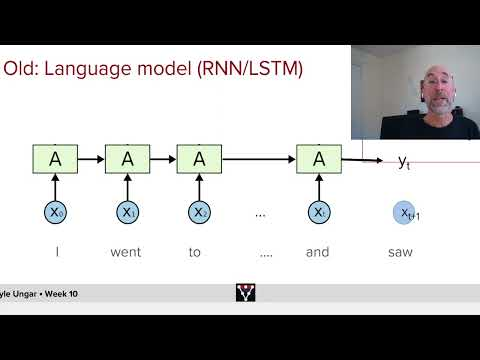

In [3]:
from IPython.display import YouTubeVideo
YouTubeVideo('rqe7P2A1gL4')

In [4]:
# @markdown What is your Pennkey and pod? (text, not numbers, e.g. bfranklin)
my_pennkey = "pawan"  # @param {type:"string"}
my_pod = "pal"  # @param {type:"string"}
my_email = "akkip9@gmail.com "  # @param {type:"string"}
tutorial = "W10D1"

In [5]:
# @title Feedback setup (run this cell)

# Feedback with Datatops
from vibecheck import DatatopsContentReviewContainer
from datatops import Datatops

feedback_dtid = "62a48t3w"
feedback_name = "cis522_feedback"
quiz_dtid = "lxx8szk1"
quiz_name = "cis522_quiz"
dt_url = "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab/"

# Instantiate the Datatops client
dt = Datatops(dt_url)
quizdt = dt.get_project(quiz_name, user_key=quiz_dtid)


In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(522)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

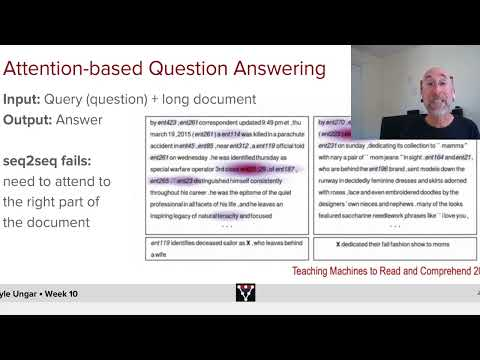

In [7]:
from IPython.display import YouTubeVideo
YouTubeVideo('ELRVHvQdXHs')


# Attention

Last week, we discussed natural language processing and the state of the art circa the early 2010s. In this tutorial, we will discuss the attention mechanism and how it can be used to improve the performance of a neural network, and we will implement attention and Transformer models.


---

Previously, we discussed an encoder-decoder architecture based on two RNNs for sequence to sequence learning. Specifically, the RNN encoder transforms a variable-length sequence into a fixed-shape context variable, then the RNN decoder generates the output (target) sequence token by token based on the generated tokens and the context variable. However, even though not all the input (source) tokens are useful for decoding a certain token, the same context variable that encodes the entire input sequence is still used at each decoding step. It is challenging for the models to deal with long sentences.

In [Bahdanau et al., 2014], the authors proposed a technique called attention. When predicting a token, if not all the input tokens are relevant, the model aligns (or attends) only to parts of the input sequence that are relevant to the current prediction.

<img width="733" alt="image" src="https://user-images.githubusercontent.com/693511/226738862-12a6199e-f204-4e9b-8af5-2a23a946802c.png">

<small>An example of attention matrix. Taken from [arxiv.1409.0473]. Don't worry too much about how we derived this just yet!</small>


## 1.a: Computing attention

To calculate the attention mechanism we make use of Queries, Keys and Values. These tensors are each a transformation of the input vector:

In an attention mechanism the context vector is computed as a weighted sum of values, where the weight assigned to each value is computed through an attention score. The score is usually the dot product between the query and key. The scores then go through the softmax function to yield a set of weights whose sum equals 1 — in other words, the weights are normalized so that every target token is assigned a "how much does this token matter" value for each output token.

The query is from the decoder hidden state whereas the key and value are from the encoder hidden state.

Take a minute and look at this article. It has detailed graphical explanation on how to calculate attention scores.
https://towardsdatascience.com/illustrated-self-attention-2d627e33b20a

Attention mechanisms in machine learning have three components:

 - the query Q (an embedding of the target word)
 - the keys K (an embedding of the source words)
 - the values V (a function of K... you can think of these as the database lookup values that correspond to K)

Generally the number and dimensionality of queries and values can all be different.

### The attention algorithm

To give a concrete example, let's imagine a simple, single-sentence document. When I look at a sentence and see a word $q$, I want to know which word $k$ in the document is most relevant to understand what $q$ means. In other words, given a "database" of key-value pairs, I want to find the [set of] keys that best match my query.

We'll start by constructing a query vector space $Q = $X \dot W_Q^T$ where $X$ is the input sequence (i.e., our starting sentence that has been tokenized and embedded) and $W_Q$ is a matrix of weights that we'll learn.

Next, we'll think of each word in the sentence as keys that we can use to "look up" the answer to our query; mathematically, we'll do the same as the above for the keys $K = X \dot W_K^T$, and the value tensor $V = X \dot W_V^T$.

For each pair of words $(q, k)$, we'll compute a score $s(q, k)$ that tells us how relevant $k$ is to $q$. We'll do this by taking the dot product of the query and key vectors, $Q \cdot K^T$.

Finally, we can compute the final output of our attention head; $A = softmax(s(Q, K)) \cdot V$. This is the weighted sum of the values, where the weights are the attention scores.


We don't know ahead of time what $Q$, $K$, $V$ should be; we'll learn the weights from the data via backpropagation.


In general, we'll use existing packages to implement attention. However, it's important to understand the code behind the magic, so we'll implement a simple attention mechanism in the next section using PyTorch.

## Quiz!

Are you still with us? This was a complicated concept! Test your knowledge and intuitions about the algorithm so far. Feel free to play with the code below and come back to these questions after manipulating the attention block!

**We compute `embed_K("dog")` and `embed_Q("dog")`, and then take the dot-product. If you take the dot product of two identical vectors, you should get out 1.0. Why don't we get 1.0 when we take the dot product of these two embeddings of the same word?**

In [9]:
why_k_embed_q_embed = "tashu" #@param {type:"string"}

In [10]:
#@title .
DatatopsContentReviewContainer(
    "",
    "W10D1_Attention",
    {
        "url": dt_url,
        "name": feedback_name,
        "user_key": feedback_dtid,
    }
).render()

In [11]:
#@title Run this if above link is broken

url = "https://jalammar.github.io/images/seq2seq_7.mp4"
from IPython.display import HTML
HTML(f"""<video src={url} width=500 controls/>""")

In [12]:
# Download the IMDB sentiment analysis dataset using PyTorch + torchtext
# https://pytorch.org/text/stable/datasets.html#imdb
from torchtext.datasets import IMDB
from torch.utils.data import DataLoader

_BATCH_SIZE = 32
train_data, test_data = IMDB(split=("train", "test"))

# Create a vocabulary from the training data
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer("basic_english")
vocab = build_vocab_from_iterator(
    map(lambda x: tokenizer(x[1]), train_data), specials=["<unk>", "<pad>"]
)

# Add the labels to the vocabulary
vocab.set_default_index(vocab["<unk>"])

# Create the data loaders
from torchtext.data.functional import to_map_style_dataset
from torch.nn.utils.rnn import pad_sequence


def generate_batch(batch, sentence_length=_BATCH_SIZE):
    label_list, text_list = [], []
    for _label, _text in batch:
        label_list.append(_label)
        processed_text = torch.tensor([vocab[token] for token in tokenizer(_text)])
        processed_text = torch.cat(
            [
                processed_text,
                torch.tensor(
                    [vocab["<pad>"]] * (sentence_length - len(processed_text))
                ),
            ]
        ).long()
        text_list.append(processed_text)
    label_list = torch.tensor(label_list)
    # Pad the text sequences, guarantee that all sequences are of the same length
    text_list = pad_sequence(text_list, batch_first=True, padding_value=vocab["<pad>"])
    # Truncate the text sequences
    text_list = text_list[:, :sentence_length]
    return (label_list, text_list)


train_iter = DataLoader(
    to_map_style_dataset(train_data),
    batch_size=_BATCH_SIZE,
    shuffle=True,
    collate_fn=generate_batch,
    drop_last=True,
)
test_iter = DataLoader(
    to_map_style_dataset(test_data),
    batch_size=_BATCH_SIZE,
    shuffle=True,
    collate_fn=generate_batch,
    drop_last=True,
)


## Positional Encoding

Attn doesn't preserve sequence. It only counts importance, not the relation or order. And order matters in language!

Using varying frequencies of sine and cosine functions of different frequencies, we can create a vector that encodes the relative position of a token in a sequence that lets the neural network decide for itself which frequencies it cares about alongside the other features it's learning.

Video available at https://youtube.com/watch?v=FoRWkEAJDtg


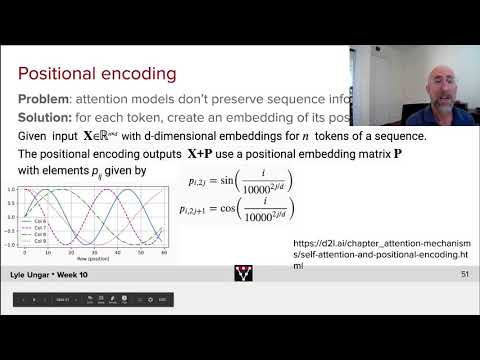

In [13]:
#@title Video : Positional Encoding
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="FoRWkEAJDtg", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

import time
try: t0;
except NameError: t0=time.time()

video

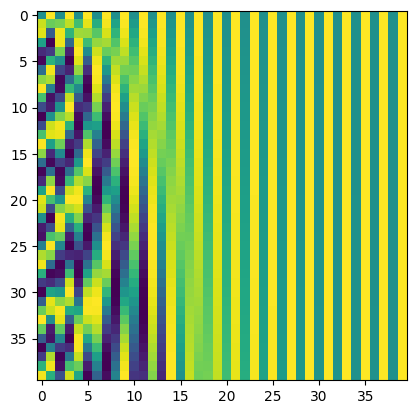

In [14]:
from matplotlib import pyplot as plt


class PositionalEncoder(nn.Module):
    def __init__(self, embed_dim, max_len=1000):
        super().__init__()
        self.position_embedding = torch.zeros((1, max_len, embed_dim))
        i = torch.arange(max_len, dtype=torch.float32).reshape(-1, 1)
        j2 = torch.arange(0, embed_dim, step=2, dtype=torch.float32)
        x = i / torch.pow(10000, j2 / embed_dim)
        self.position_embedding[..., 0::2] = torch.sin(x)
        self.position_embedding[..., 1::2] = torch.cos(x)

    def forward(self, x):
        x_plus_p = x + self.position_embedding[:, : x.shape[1]]
        return x_plus_p



n_tokens, embed_dim = 40, 40
pos_enc = PositionalEncoder(embed_dim)
p = pos_enc(torch.zeros((1, n_tokens, embed_dim)))
plt.imshow(p.squeeze())


In [15]:
#@title .
DatatopsContentReviewContainer(
    "",
    "W10D1_PositionalEncoding",
    {
        "url": dt_url,
        "name": feedback_name,
        "user_key": feedback_dtid,
    }
).render()

---

---


# Transformers

Take a deep breath. It is finally time to apply everything we have learned in the last three notebooks — it's Transformers time!

Like CNNs, the term "Transformer" refers not to a specific architecture, but a _style_ of architecture. And this base model architecture has been the foundation of many very successful models, some of which you may be using right now to write your answers to this notebook, and others of which you might be asking to make you reservations at a restaurant tonight. It has seen tremendous use in the NLP space, and there have been effforts to extend it to the audio and visual domains as well. The original paper that explained the Transformer architecture had the rather aggressive title, "Attention is all you need" — but so far, it has proven to be more correct than many expected!

[Attention Is All You Need (Vaswani et al. 2017)](https://arxiv.org/abs/1706.03762), is very readable and you are encouraged to take a look.

The Transformer model is fundamentally an encoder-decoder model that operates on sequences of tokens. Both the encoder and decoder components are composed of stacks of submodules that use **only** attention mechanisms and linear weights to learn (there are no CNNs or RNNs). The architecture schematic looks like the following:

![transformer architecture](https://d2l.ai/_images/transformer.svg)

Let's break this down, because while the architecture can seem very daunting, you now know all the pieces that go into it!

* An encoder/decoder network is familiar territory; we've written autoencoders before, and used this style of model extensively for image generation in a previous week.
* Positional encoding: We wrote this from scratch just now!
* Sequences of tokens? We not only know what that looks like — we've written our own tokenizers!
* Attention is the trickiest piece, but we've implemented it from scratch above. Nothing scary here!

In the rest of this section we will be going over the various building blocks that go into Transformers. The emphasis is on understanding what all the pieces do and how they fit together, so while we _will_ train a transformer in this notebook, you should not expect it to write your homework any time soon.

*Note:* Many of the images in this section are taken from Dive Into Deep Learning's chapter on [Attention Mechanisms](https://d2l.ai/chapter_attention-mechanisms/index.html). You are encouraged to check that out for additional details and implementations.

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('Adh2ldd1oIQ')

### Self-Attention

Transformers make use of something called self-attention as a critical component to the entire operation. What does that mean in the context of attention mechanisms? If you recall, attention mechanisms in machine learning have three components:

 - the values V (the things you perceive i.e. model inputs)
 - the query Q (the thing you want to attend to)
 - the keys K (a mapping between queries and values)

Generally the number and dimensionality of queries and values can all be different. In self-attention, the queries, keys, and values are all drawn from the same set of inputs. In other words, we don't need to specify anything about what and how queries and keys are formed, as they come straight from the data just like the values!

Take a minute and check out the following article; It has detailed graphical explanation on how to calculate attention scores
https://towardsdatascience.com/illustrated-self-attention-2d627e33b20a

Ok, so we know that our queries, keys, and values come from our input sequence, but which attention mechanism should we use?

Video available at https://youtube.com/watch?v=VtaGIp_9j1w


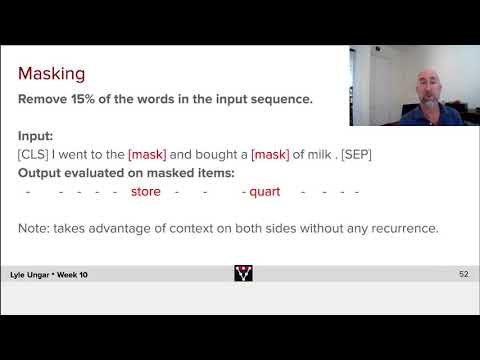

In [16]:
### Masked Scaled Dot Product Attention
#@title Video : Masking
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="VtaGIp_9j1w", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

#### Multi-Head Attention Module
Next we will show you how to implement the forward method of a PyTorch module for handling the multi-head attention mechanism. Each of the Q, K, and V inputs need to be run through their corresponding linear layers and then transformed using `mha_transform_input`. You then pass these to our scaled dot product attention module, transform that output back using `mha_transform_output`, and then run that though the corresponding output linear layer.

*NOTE:* In the original Transformers paper, the linear layers were just weight matrices with no bias term which is reproduced here by using `Linear` layers and setting bias to False.

In [17]:
def masked_softmax(x, mask):
    """Applies softmax on a masked version of the input.
    Args:
      x (n_batch, n_tokens, t_tokens): - the scaled dot product of Q and K
      mask (n_batch, n_tokens): - binary mask, all values = 0 will be set to -inf
    Returns:
      (n_batch, n_tokens, n_tokens): the result of applying softmax along the last
        dimension of the masked input.
    """
    return F.softmax(x.masked_fill_(mask.unsqueeze(1) == 0, float("-inf")), dim=-1)


def mha_transform_input(x, n_heads, head_dim):
    """Restructure the input tensors to compute the heads in parallel
    Requires that head_dim = embed_dim / n_heads
    Args:
      x (n_batch, n_tokens, embed_dim): input tensor, one of queries, keys, or values
      n_heads (int): the number of attention heads
      head_dim (int): the dimensionality of each head
    Returns:
      (n_batch*n_heads, n_tokens, head_dim): 3D Tensor containing all the input heads
    """
    n_batch, n_tokens, _ = x.shape
    x = x.reshape((n_batch, n_tokens, n_heads, head_dim))
    x = x.permute(0, 2, 1, 3)
    return x.reshape((n_batch * n_heads, n_tokens, head_dim))


def mha_transform_output(x, n_heads, head_dim):
    """Restructures the output back to the original format
    Args:
      x (n_bacth*n_heads, n_tokens, head_dim): multi-head representation tensor
      n_heads (int): the number of attention heads
      head_dim (int): the dimensionality of each head
    Returns:
      (n_batch, n_tokens, embed_dim): 3D Tensor containing all the input heads
    """
    n_concat, n_tokens, _ = x.shape
    n_batch = n_concat // n_heads
    x = x.reshape((n_batch, n_heads, n_tokens, head_dim))
    x = x.permute(0, 2, 1, 3)
    return x.reshape((n_batch, n_tokens, n_heads * head_dim))


class ScaledDotProductAttention(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.embed_dim = embed_dim

    def forward(self, queries, keys, values, mask):
        """
        Args:
          queries (n_batch, n_tokens, embed_dim): queries (Q) tensor
          keys (n_batch, n_tokens, embed_dim): keys (K) tensor
          values (n_batch, n_tokens, embed_dim): values (V) tensor
          mask (n_batch, n_tokens): binary mask tensor
        Returns:
          (n_batch, n_tokens, embed_dim): scaled dot product attention tensor
        """
        scaled_dot_product = torch.bmm(queries, torch.transpose(keys, 1, 2)) / np.sqrt(
            self.embed_dim
        )
        masked_softmax_scores = masked_softmax(scaled_dot_product, mask)
        attention = torch.bmm(masked_softmax_scores, values)
        return attention


class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, embed_dim):
        super().__init__()
        self.n_heads = n_heads
        self.head_dim = embed_dim // n_heads

        self.attention = ScaledDotProductAttention(embed_dim)
        self.query_fc = nn.Linear(embed_dim, embed_dim, bias=False)
        self.key_fc = nn.Linear(embed_dim, embed_dim, bias=False)
        self.value_fc = nn.Linear(embed_dim, embed_dim, bias=False)
        self.out_fc = nn.Linear(embed_dim, embed_dim, bias=False)

    def forward(self, queries, keys, values, mask):
        """
        Args:
          queries (n_batch, n_tokens, embed_dim): queries (Q) tensor
          keys (n_batch, n_tokens, embed_dim): keys (K) tensor
          values (n_batch, n_tokens, embed_dim): values (V) tensor
          mask (n_batch, n_tokens): binary mask tensor
        Returns:
          (n_batch, n_tokens, embed_dim): multi-head attention tensor
        """
        q_heads = mha_transform_input(
            self.query_fc(queries), self.n_heads, self.head_dim
        )
        k_heads = mha_transform_input(self.key_fc(keys), self.n_heads, self.head_dim)
        v_heads = mha_transform_input(
            self.value_fc(values), self.n_heads, self.head_dim
        )

        attention_heads = self.attention(q_heads, k_heads, v_heads, mask)
        attention = self.out_fc(
            mha_transform_output(attention_heads, self.n_heads, self.head_dim)
        )
        return attention


Video available at https://youtube.com/watch?v=_sKZpAptIZk


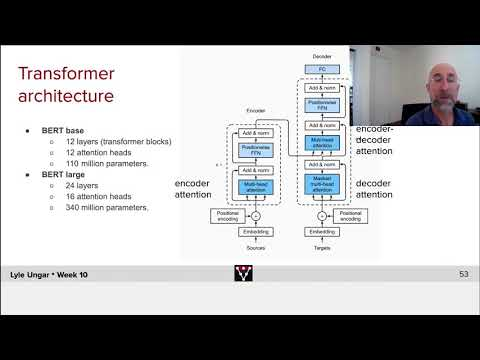

In [18]:
#@title Video : Transformer Architecture
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="_sKZpAptIZk", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

## The Architecture: Encoder

We now have almost everything we need to assemble the full Transformer network. There are just two more modules we need to quickly discuss, and then we will get to putting them all together.

Transformer architecture for reference:
<div>
<img src="https://d2l.ai/_images/transformer.svg" width="275"/>
</div>

First, there is the residual layer norm that appears after every other component. In all cases, this takes the output of the previous component, sums it with the input to that component (the residual connection), and then normalizes the result across the layer.

Second is the positionwise feed forward network that appears after the attention components. It is a two layer fully connected module with a ReLU activation in between.

These are provided for reference here. Note that dropout would normally be applied in various places in these modules during training, but we have omitted it for clarity.

In [19]:
class ResidualNorm(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x, residual):
        return self.norm(x + residual)


class Feedforward(nn.Module):
    def __init__(self, embed_dim, hidden_dim):
        super().__init__()
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, embed_dim)

    def forward(self, x):
        return self.fc2(F.relu(self.fc1(x)))


Now that we have all the modules we need, we can begin assembling the bigger modules. First we will look at the Encoder Block. The actual encoder will be made up of some number of these stacked together.

#### Exercise 1.1: Encoder Block Module
In this exercise you will create the forward method of the PyTorch module representing the Encoder Block of the Transformer. The Encoder Block has the following architecture:
1. a multi-head attention module using self-attention
2. 1st residual layer norm
3. feed-forward model
4. 2nd residual layer norm


In [21]:
class EncoderBlock(nn.Module):
    def __init__(self, n_heads, embed_dim, hidden_dim):
        super().__init__()
        self.attention = MultiHeadAttention(n_heads, embed_dim)
        self.norm1 = ResidualNorm(embed_dim)
        self.feedforward = Feedforward(embed_dim, hidden_dim)
        self.norm2 = ResidualNorm(embed_dim)

    def forward(self, src_tokens, src_mask):
        """
        Args:
          src_tokens (n_batch, n_tokens, embed_dim): the source sequence
          src_mask (n_batch, n_tokens): binary mask over the source
        Returns:
          (n_batch, n_tokens, embed_dim): the encoder state
        """
        ####################################################################
        # Fill in missing code below (...),
        # then remove or comment the line below to test your function
        raise NotImplementedError("EncoderBlock")
        ####################################################################
        # First compute self-attention on the source tokens by passing them in
        # as the queries, keys, and values to the attention module.
        self_attention = ...
        # Next compute the norm of the self-attention result with a residual
        # connection from the source tokens
        normed_attention = ...
        # Pass the normed attention result through the feedforward component
        ff_out = ...
        # Finally compute the norm of the feedforward output with a residual
        # connection from the normed attention output
        out = ...
        return out


# Uncomment below to test your module
# n_heads, batch_size, n_tokens, embed_dim, hidden_dim = 2, 1, 3, 4, 8
# tokens = torch.normal(0, 1, (batch_size, n_tokens, embed_dim))
# mask = torch.ones((batch_size, n_tokens))
# encoder = EncoderBlock(n_heads, embed_dim, hidden_dim)
# encoder(tokens, mask)

Now that we have our Encoder Block, we can chain these together in a stack to get the full Encoder module. We will include the embedding layer and positional encoding step of the source tokens here as well. The input to this module then will be a tensor of a batch of token IDs and corresponding mask.

For instance, if our entire corpus was the English sentence: `Cat sat on the mat` and we tokenized by word, our vocab size would be 5 as there are 4 unique words. Converting this sentence to IDs would be `[[0,1,2,3,4]]`.

The code for the Encoder module is provided below.

In [22]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, n_heads, n_blocks):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.positional_encoding = PositionalEncoder(embed_dim)
        self.encoder_blocks = nn.ModuleList(
            [EncoderBlock(n_heads, embed_dim, hidden_dim) for _ in range(n_blocks)]
        )

    def forward(self, src_tokens, src_mask):
        x = self.embedding(src_tokens)
        x = self.positional_encoding(x)
        for block in self.encoder_blocks:
            x = block(x, src_mask)
        return x


# Uncomment below to test your module
# vocab_size = 5
# n_blocks, n_heads, batch_size, embed_dim, hidden_dim = 10, 2, 1, 4, 8
# enc = Encoder(vocab_size, embed_dim, hidden_dim, n_heads, n_blocks)
# src_tokens = torch.IntTensor([[0, 1, 2, 3, 4]])
# src_mask = torch.IntTensor([[1, 1, 1, 1, 1]])
# enc(src_tokens, src_mask)

### The Decoder

Like the encoder, the decoder is made up of a stack of repeating Decoder Blocks. Decoder Blocks are similar to the Encoder ones with an additional multi-head attention component that doesn't use self-attention, but instead gets the queries from the decoder's self-attention component and the keys and values from the encoder's output.

#### Exercise 1.2: Decoder Block Module
In this exercise you will create the forward method of the PyTorch module representing the Decoder Block of the Transformer. The Decoder Block has the following architecture:
1. a multi-head attention using self-attention
2. 1st residual layer norm
3. a 2nd multi-head attention that incorporates the encoder output
4. 2nd residual layer norm
5. feed-forward model
6. 3rd residual layer norm

In [23]:
class DecoderBlock(nn.Module):
    def __init__(self, n_heads, embed_dim, hidden_dim):
        super().__init__()
        self.self_attention = MultiHeadAttention(n_heads, embed_dim)
        self.norm1 = ResidualNorm(embed_dim)
        self.encoder_attention = MultiHeadAttention(n_heads, embed_dim)
        self.norm2 = ResidualNorm(embed_dim)
        self.feedforward = Feedforward(embed_dim, hidden_dim)
        self.norm3 = ResidualNorm(embed_dim)

    def forward(self, tgt_tokens, tgt_mask, encoder_state, src_mask):
        """
        Args:
          tgt_tokens (n_batch, n_tokens, embed_dim): the target sequence
          tgt_mask (n_batch, n_tokens): binary mask over the target tokens
          encoder_state (n_batch, n_tokens, embed_dim): the output of the encoder pass
          src_mask (n_batch, n_tokens): binary mask over the source tokens
        Returns:
          (n_batch, n_tokens, embed_dim): the decoder state
        """
        ####################################################################
        # Fill in missing code below (...),
        # then remove or comment the line below to test your function
        raise NotImplementedError("DecoderBlock")
        ####################################################################
        # First compute self-attention on the target tokens by passing them in
        # as the queries, keys, and values to the attention module along with the
        # target mask.
        self_attention = ...
        # Next compute the norm of the self-attention result with a residual
        # connection from the target tokens
        normed_self_attention = ...
        # Compute the encoder attention by using the normed self-attention output as
        # the queries and the encoder state as the keys and values along with the
        # source mask.
        encoder_attention = ...
        # Next compute the norm of the encoder attention result with a residual
        # connection from the normed self-attention
        normed_encoder_attention = ...
        # Pass the normed encoder attention result through the feedforward component
        ff_out = ...
        # Finally compute the norm of the feedforward output with a residual
        # connection from the normed attention output
        out = ...
        return out


# Uncomment below to test your module
# n_heads, batch_size, n_tokens, embed_dim, hidden_dim = 2, 1, 3, 4, 8
# tokens = torch.normal(0, 1, (batch_size, n_tokens, embed_dim))
# src_mask = torch.ones((batch_size, n_tokens))
# tgt_mask = torch.ones((batch_size, n_tokens))
# encoder = EncoderBlock(n_heads, embed_dim, hidden_dim)
# decoder = DecoderBlock(n_heads, embed_dim, hidden_dim)
# encoder_state = encoder(tokens, src_mask)
# decoder(tokens, tgt_mask, encoder_state, src_mask)

The Decoder module ends up just the same as the Encoder module with one key difference: the forward method needs to also accept the output of the encoder as well as the source token mask.

For instance, let's assume we are doing a translation task and want to translate the English `Cat sat on the mat` into the French `Chat assis sur le tapis`. Out target vocab size is also 5 and would be similarly converted into IDs as `[[0,1,2,3,4]]`.

The code for the Decoder module is presented below.

In [24]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, n_heads, n_blocks):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.positional_encoding = PositionalEncoder(embed_dim)
        self.decoder_blocks = nn.ModuleList(
            [DecoderBlock(n_heads, embed_dim, hidden_dim) for _ in range(n_blocks)]
        )

    def forward(self, tgt_tokens, tgt_mask, encoder_state, src_mask):
        x = self.embedding(tgt_tokens)
        x = self.positional_encoding(x)
        for block in self.decoder_blocks:
            x = block(x, tgt_mask, encoder_state, src_mask)
        return x

# Uncomment below to test your module
# vocab_size = 5
# n_blocks, n_heads, batch_size, embed_dim, hidden_dim = 10, 2, 1, 4, 8
# tgt_tokens = torch.IntTensor([[0, 1, 2, 3, 4]])
# tgt_mask = src_mask = torch.IntTensor([[1, 1, 1, 1, 1]])
# enc_state = torch.randn((1, 5, 4))
# dec = Decoder(vocab_size, embed_dim, hidden_dim, n_heads, n_blocks)
# dec(tgt_tokens, tgt_mask, enc_state, src_mask)

### The Full Transformer Model

We can now put the Encoder and Decoder together to produce the full Transformer model.



#### Exercise 1.3: Transformer Module

In the last exercise for this section you will implement the forward method of the full Transformer module. First you will apply the source tokens and mask to the Encoder to get its output, then use that along with the target tokens and mask to produce the Decoder output. Finally we run the Decoder output through a linear layer to transform the embeddings back into vocab ID scores in order to determine the actual next word prediction.

In [25]:
class Transformer(nn.Module):
    def __init__(
        self, src_vocab_size, tgt_vocab_size, embed_dim, hidden_dim, n_heads, n_blocks
    ):
        super().__init__()
        self.encoder = Encoder(src_vocab_size, embed_dim, hidden_dim, n_heads, n_blocks)
        self.decoder = Decoder(tgt_vocab_size, embed_dim, hidden_dim, n_heads, n_blocks)
        self.out = nn.Linear(embed_dim, tgt_vocab_size)

    def forward(self, src_tokens, src_mask, tgt_tokens, tgt_mask):
        ####################################################################
        # Fill in missing code below (...),
        # then remove or comment the line below to test your function
        raise NotImplementedError("Transformer")
        ####################################################################
        # Compute the encoder output state from the source tokens and mask
        encoder_state = ...
        # Compute the decoder output state from the target tokens and mask as well
        # as the encoder state and source mask
        decoder_state = ...
        # Compute the vocab scores by passing the decoder state through the output
        # linear layer
        out = ...
        return out


# Uncomment below to test your module
# src_vocab_size = tgt_vocab_size = 5
# n_blocks, n_heads, batch_size, embed_dim, hidden_dim = 10, 2, 1, 4, 8
# src_tokens = tgt_tokens = torch.IntTensor([[0,1,2,3,4]])
# src_mask = tgt_mask = torch.IntTensor([[1,1,1,1,1]])

# transformer = Transformer(src_vocab_size, tgt_vocab_size, embed_dim, hidden_dim, n_heads, n_blocks)
# transformer(src_tokens, src_mask, tgt_tokens, tgt_mask)

### Summary
We've covered all the building blocks that make up the Transformer network architecture from the attention mechanism up to the fully combined encoder-decoder setup. The module versions presented here were often simplified in some ways and made more verbose in others to emphasize what each component is doing.

You should now feel that you have a good understanding of the Transformer architecture and how it works. In the next notebook we will look at how to train this model, and see what the current state of the art is for machine learning practitioners in industry, academia... and in the emerging world of large language models like GPT-3 and GPT-4.

We hope that we have "unmagicked" the transformer architecture for you in the same way we unmagicked stable diffusion together. These world-changing models are just a combination of a few simple ideas that have been around for a long time!

# Wrap Up

### Quiz

**In a deep attention network, why would you expect part of speech tagging to be done closer to the input, and co-reference to be done more deeply in the network?**


In [26]:
why_pos_vs_coreference = "" #@param {type:"string"}

**In the original Transformer architecture, the authors used both Dropout _and_ output masking. Why do we need to mask some of the target tokens?**

In [ ]:
dropout_and_masking = "" #@param {type:"string"}

In [ ]:
# @title Submit your quiz answers (run this cell to submit)

quizdt.store(
    dict(
        notebook=tutorial,
        my_pennkey=my_pennkey,
        my_pod=my_pod,
        my_email=my_email,
        why_k_embed_q_embed=why_k_embed_q_embed,
        why_pos_vs_coreference=why_pos_vs_coreference,
        dropout_and_masking=dropout_and_masking,
    )
)